In [1]:
import pandas as pd
from hnmchallenge.data_reader import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from hnmchallenge.evaluation.python_evaluation import map_at_k
from hnmchallenge.models_prediction.recs_interface import RecsInterface
from hnmchallenge.datasets.all_items_last_month_last_week import AILMLWDataset
from hnmchallenge.datasets.all_items_last_month_last_2nd_week import AILML2WDataset
from hnmchallenge.datasets.all_items_last_month_last_3rd_week import AILML3WDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset
from hnmchallenge.constant import *

In [2]:
dataset = AILMLWDataset()
articles_df = dataset.get_articles_df()
fd = dataset.get_full_data()
customers_df=dataset.get_customers_df()

In [3]:
g_sum = fd.groupby(['t_dat','article_id'])['article_id'].count()

In [4]:
g_sum

t_dat       article_id
2018-09-20  0               6
            1              12
            2               9
            3             242
            4             443
                         ... 
2020-09-22  104542          1
            104543          1
            104544          2
            104545          1
            104546          1
Name: article_id, Length: 7443545, dtype: int64

In [5]:
fd[fd["article_id"]==104546]

,t_dat,customer_id,article_id,price,sales_channel_id
31787321,2020-09-22,178189,104546,0.033881,2


In [6]:
df = dataset.get_full_data()

In [7]:
df['t_dat'] = pd.to_datetime(df['t_dat']) - pd.to_timedelta(7, unit='d')
df = df.groupby(['article_id', pd.Grouper(key='t_dat', freq='M')])['article_id'].count().to_frame("count").reset_index()
      

In [8]:
df[df["article_id"]==1]

,article_id,t_dat,count
9,1,2018-09-30,89
10,1,2018-10-31,110
11,1,2018-11-30,52
12,1,2018-12-31,125
13,1,2019-01-31,36
14,1,2019-02-28,11
15,1,2019-03-31,5
16,1,2019-04-30,1
17,1,2019-05-31,1
18,1,2019-06-30,1


In [9]:
fd = dataset.get_full_data()

In [10]:
fd["last_buy"] = fd.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(max)
fd["first_buy"] = fd.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(min)
fd["life"] = (fd["last_buy"] - fd["first_buy"])

In [11]:
fd=fd.drop_duplicates("article_id")

In [12]:
fd['life'] = pd.to_numeric(fd['life'].dt.days, downcast='integer')

In [13]:

fd['life']=fd['life']/30
fd['life']=fd['life'].astype(int)

In [14]:
fd

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,life
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,8
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,15
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,8
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,16
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,17
...,...,...,...,...,...,...,...,...
31785745,2020-09-22,961844,104542,0.067780,2,2020-09-22,2020-09-22,0
31785950,2020-09-22,1362203,104543,0.038119,1,2020-09-22,2020-09-22,0
31785951,2020-09-22,1362203,104544,0.016017,1,2020-09-22,2020-09-22,0
31786216,2020-09-22,261358,104545,0.033881,2,2020-09-22,2020-09-22,0


In [15]:
df_std = np.std(fd["life"])
df_std

6.242322669834023

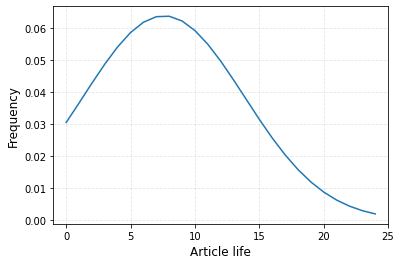

In [16]:

import matplotlib.pyplot as plt
import scipy.stats as stats

df_mean = np.mean(fd["life"])
df_std = np.std(fd["life"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(fd["life"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(fd["life"].sort_values(), pdf)
plt.xlim([-1,25])  
plt.xlabel("Article life", size=12)    
plt.ylabel("Frequency", size=12)                
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

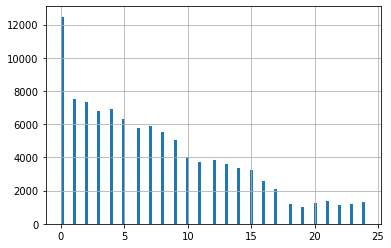

In [17]:
hist = fd.life.hist(bins=100)

In [18]:
fd = dataset.get_full_data()
t_per_day = fd.groupby('t_dat',as_index=False).count()

/tmp/ipykernel_2155613/272158277.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(x=pd.datetime(2019,1,1), c='green')
/tmp/ipykernel_2155613/272158277.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(x=pd.datetime(2020,1,1), c='green')


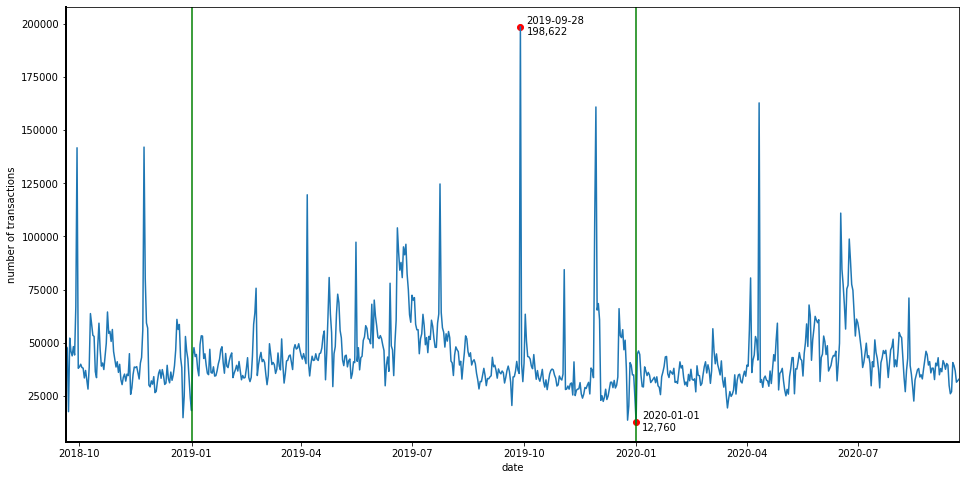

In [19]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data=t_per_day, x='t_dat',y='customer_id')

ax.set_xlabel('date')
ax.set_ylabel('number of transactions')

ax.axvline(x=pd.datetime(2019,1,1), c='green')
ax.axvline(x=pd.datetime(2020,1,1), c='green')

max_t = t_per_day['customer_id'].max()
max_t_date = t_per_day[t_per_day['customer_id']==max_t]['t_dat']
ax.scatter(max_t_date, max_t, c='red')
ax.text(max_t_date+pd.DateOffset(days=5), max_t-4000, '{}\n{:,d}'.format(max_t_date.iloc[0].date(), max_t))

min_t = t_per_day['customer_id'].min()
min_t_date = t_per_day[t_per_day['customer_id']==min_t]['t_dat']
ax.scatter(min_t_date, min_t, c='red')
ax.text(min_t_date+pd.DateOffset(days=5), min_t-4000, '{}\n{:,d}'.format(min_t_date.iloc[0].date(), min_t))
ax.set_xlim(fd['t_dat'].min(),fd['t_dat'].max())

for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')

plt.show()

In [20]:
fd = dataset.get_full_data()
data=fd.groupby(['t_dat','article_id'])['article_id'].count().to_frame("count").reset_index()
      

In [21]:
data

,t_dat,article_id,count
0,2018-09-20,0,6
1,2018-09-20,1,12
2,2018-09-20,2,9
3,2018-09-20,3,242
4,2018-09-20,4,443
...,...,...,...
7443540,2020-09-22,104542,1
7443541,2020-09-22,104543,1
7443542,2020-09-22,104544,2
7443543,2020-09-22,104545,1


In [22]:
df = dataset.get_full_data()

In [23]:
df['t_dat'] = pd.to_datetime(df['t_dat']) - pd.to_timedelta(7, unit='d')
df = df.groupby(['article_id', pd.Grouper(key='t_dat', freq='M')])['article_id'].count().to_frame("count").reset_index()

In [24]:
df['month'] = pd.DatetimeIndex(df['t_dat']).month

In [25]:
df1=df.drop(['t_dat'],axis=1)

In [26]:
df1

,article_id,count,month
0,0,118,9
1,0,183,10
2,0,149,11
3,0,121,12
4,0,50,1
...,...,...,...
768310,104542,1,9
768311,104543,1,9
768312,104544,2,9
768313,104545,1,9


In [27]:
df2=df1.groupby(['article_id'])['count'].sum().to_frame("count_total").reset_index()

In [28]:
df2

,article_id,count_total
0,0,633
1,1,434
2,2,42
3,3,1836
4,4,1792
...,...,...
104542,104542,1
104543,104543,1
104544,104544,2
104545,104545,1


In [29]:
df3=pd.merge(df1,df2,on='article_id')

In [30]:
df3

,article_id,count,month,count_total
0,0,118,9,633
1,0,183,10,633
2,0,149,11,633
3,0,121,12,633
4,0,50,1,633
...,...,...,...,...
768310,104542,1,9,1
768311,104543,1,9,1
768312,104544,2,9,2
768313,104545,1,9,1


In [31]:
df3["total in month"]=df3["count"]/df3["count_total"]

In [32]:
df3["overall"]=df3["count"]/104547

In [33]:
df3

,article_id,count,month,count_total,total in month,overall
0,0,118,9,633,0.186414,0.001129
1,0,183,10,633,0.289100,0.001750
2,0,149,11,633,0.235387,0.001425
3,0,121,12,633,0.191153,0.001157
4,0,50,1,633,0.078989,0.000478
...,...,...,...,...,...,...
768310,104542,1,9,1,1.000000,0.000010
768311,104543,1,9,1,1.000000,0.000010
768312,104544,2,9,2,1.000000,0.000019
768313,104545,1,9,1,1.000000,0.000010


In [34]:
import math
df3['log'] = df3.apply(lambda x: math.log(x['total in month'],2),axis=1)
df3['prod'] = df3['total in month']*df3['log'].abs()

In [35]:
df4 = df3.groupby(['article_id'])['prod'].sum().to_frame("entropy").reset_index()

In [36]:
sept=df3[df3["month"]==9]

In [37]:
sept

,article_id,count,month,count_total,total in month,overall,log,prod
0,0,118,9,633,0.186414,0.001129,-2.423419,0.451759
9,1,89,9,434,0.205069,0.000851,-2.285818,0.468751
22,2,23,9,42,0.547619,0.000220,-0.868755,0.475747
26,3,1319,9,1836,0.718410,0.012616,-0.477121,0.342769
35,4,1312,9,1792,0.732143,0.012549,-0.449803,0.329320
...,...,...,...,...,...,...,...,...
768310,104542,1,9,1,1.000000,0.000010,0.000000,0.000000
768311,104543,1,9,1,1.000000,0.000010,0.000000,0.000000
768312,104544,2,9,2,1.000000,0.000019,0.000000,0.000000
768313,104545,1,9,1,1.000000,0.000010,0.000000,0.000000


In [38]:
sept[sept["ov_prod"]>-0.0002]

KeyError: 'ov_prod'

In [ ]:
df3[df3["ov_prod"]>-0.0002]

,article_id,count,month,count_total,total in month,overall,log,prod,ov_log,ov_prod
7,0,1,4,633,0.001580,0.00001,-9.306062,-0.014702,-16.673792,-0.000159
8,0,1,6,633,0.001580,0.00001,-9.306062,-0.014702,-16.673792,-0.000159
16,1,1,4,434,0.002304,0.00001,-8.761551,-0.020188,-16.673792,-0.000159
17,1,1,5,434,0.002304,0.00001,-8.761551,-0.020188,-16.673792,-0.000159
18,1,1,6,434,0.002304,0.00001,-8.761551,-0.020188,-16.673792,-0.000159
...,...,...,...,...,...,...,...,...,...,...
768309,104541,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768310,104542,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768311,104543,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768313,104545,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159


In [ ]:
df3[df3["ov_prod"]>-0.0002].drop_duplicates('article_id')

,article_id,count,month,count_total,total in month,overall,log,prod,ov_log,ov_prod
7,0,1,4,633,0.001580,0.00001,-9.306062,-0.014702,-16.673792,-0.000159
16,1,1,4,434,0.002304,0.00001,-8.761551,-0.020188,-16.673792,-0.000159
25,2,1,5,42,0.023810,0.00001,-5.392317,-0.128389,-16.673792,-0.000159
32,3,1,10,1836,0.000545,0.00001,-10.842350,-0.005905,-16.673792,-0.000159
39,4,1,1,1792,0.000558,0.00001,-10.807355,-0.006031,-16.673792,-0.000159
...,...,...,...,...,...,...,...,...,...,...
768309,104541,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768310,104542,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768311,104543,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159
768313,104545,1,9,1,1.000000,0.00001,0.000000,0.000000,-16.673792,-0.000159


In [65]:
trans =dataset.get_full_data()
trans["last_buy"] = trans.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(max)
trans["first_buy"] = trans.groupby(DEFAULT_ITEM_COL)["t_dat"].transform(min)
trans["duration"] = (trans["last_buy"] - trans["first_buy"])
trans['duration'] = pd.to_numeric(trans['duration'].dt.days, downcast='integer')
trans["duration"]=trans["duration"].astype(int)

In [66]:
trans=trans[trans["duration"]>=150]

In [67]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,duration
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531
...,...,...,...,...,...,...,...,...
31788304,2020-09-22,43467,90967,0.059305,2,2020-09-22,2020-04-25,150
31788307,2020-09-22,43467,90898,0.059305,2,2020-09-22,2020-04-24,151
31788314,2020-09-22,27141,56189,0.010153,2,2020-09-22,2019-04-19,522
31788318,2020-09-22,27141,83786,0.042356,2,2020-09-22,2020-02-17,218


In [68]:
for i in range(6):
    trans[f"month_{i}"]=trans["first_buy"]+ pd.to_timedelta(i*30, unit='d')

In [69]:
trans

,t_dat,customer_id,article_id,price,sales_channel_id,last_buy,first_buy,duration,month_0,month_1,month_2,month_3,month_4,month_5
0,2018-09-20,0,0,0.050831,2,2019-06-16,2018-09-20,269,2018-09-20,2018-10-20,2018-11-19,2018-12-19,2019-01-18,2019-02-17
1,2018-09-20,0,1,0.030492,2,2019-12-27,2018-09-20,463,2018-09-20,2018-10-20,2018-11-19,2018-12-19,2019-01-18,2019-02-17
2,2018-09-20,1,2,0.015237,2,2019-05-25,2018-09-20,247,2018-09-20,2018-10-20,2018-11-19,2018-12-19,2019-01-18,2019-02-17
3,2018-09-20,1,3,0.016932,2,2020-02-08,2018-09-20,506,2018-09-20,2018-10-20,2018-11-19,2018-12-19,2019-01-18,2019-02-17
4,2018-09-20,1,4,0.016932,2,2020-03-04,2018-09-20,531,2018-09-20,2018-10-20,2018-11-19,2018-12-19,2019-01-18,2019-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31788304,2020-09-22,43467,90967,0.059305,2,2020-09-22,2020-04-25,150,2020-04-25,2020-05-25,2020-06-24,2020-07-24,2020-08-23,2020-09-22
31788307,2020-09-22,43467,90898,0.059305,2,2020-09-22,2020-04-24,151,2020-04-24,2020-05-24,2020-06-23,2020-07-23,2020-08-22,2020-09-21
31788314,2020-09-22,27141,56189,0.010153,2,2020-09-22,2019-04-19,522,2019-04-19,2019-05-19,2019-06-18,2019-07-18,2019-08-17,2019-09-16
31788318,2020-09-22,27141,83786,0.042356,2,2020-09-22,2020-02-17,218,2020-02-17,2020-03-18,2020-04-17,2020-05-17,2020-06-16,2020-07-16


In [70]:
td =dataset.get_full_data()
articles=td["article_id"].to_frame("article_id").reset_index()

In [71]:
articles=articles.drop(["index"],axis=1)
articles=articles.drop_duplicates("article_id")


In [72]:
articles

,article_id
0,0
1,1
2,2
3,3
4,4
...,...
31785745,104542
31785950,104543
31785951,104544
31786216,104545


In [91]:

for i in range(5):
    m = np.logical_or.reduce(
                [np.logical_and(trans["t_dat"] >= trans[f"month_{i}"], trans["t_dat"] <= trans[f"month_{i+1}"])]
            )
    data_df = trans.loc[m]
    data_df=data_df[["article_id",f"month_{i}"]]
    count_mb = data_df.groupby(DEFAULT_ITEM_COL).count().reset_index()
    count_mb=count_mb.drop_duplicates("article_id")
    if i==0:
        data=pd.merge(articles,count_mb, on="article_id",how="left")
    else:
        data=pd.merge(data,count_mb, on="article_id",how="left")
    data=data.fillna(0)

In [93]:
data["total"]=data[["month_0","month_1","month_2","month_3","month_4"]].sum(axis=1)

In [94]:
data

,article_id,month_0,month_1,month_2,month_3,month_4,total
0,0,211.0,141.0,176.0,83.0,28.0,639.0
1,1,149.0,77.0,59.0,126.0,23.0,434.0
2,2,35.0,4.0,2.0,0.0,0.0,41.0
3,3,1509.0,257.0,69.0,5.0,1.0,1841.0
4,4,1592.0,166.0,23.0,0.0,1.0,1782.0
...,...,...,...,...,...,...,...
104542,104542,0.0,0.0,0.0,0.0,0.0,0.0
104543,104543,0.0,0.0,0.0,0.0,0.0,0.0
104544,104544,0.0,0.0,0.0,0.0,0.0,0.0
104545,104545,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
for i in range(5):
    data[f"month_{i}"]= data[f"month_{i}"]/data["total"]

In [97]:
data=data.fillna(0)

In [98]:
data

,article_id,month_0,month_1,month_2,month_3,month_4,total
0,0,0.330203,0.220657,0.275430,0.129890,0.043818,639.0
1,1,0.343318,0.177419,0.135945,0.290323,0.052995,434.0
2,2,0.853659,0.097561,0.048780,0.000000,0.000000,41.0
3,3,0.819663,0.139598,0.037480,0.002716,0.000543,1841.0
4,4,0.893378,0.093154,0.012907,0.000000,0.000561,1782.0
...,...,...,...,...,...,...,...
104542,104542,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
104543,104543,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
104544,104544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
104545,104545,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
